## Set Up

In [0]:
#Initialize TPU
import tensorflow as tf
import os

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [0]:
#Code to install necessary libraries and perform authorization
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

#Mount google drive 
!mkdir -p drive 
!google-drive-ocamlfuse drive

#Path
import os
os.chdir('/content/drive/sp500AlgoTrading_Classification')

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.21-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.21-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.21-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

## Data Exploration
Training and validation data consists of intraday by 10 minute data from 05/08/2008 to 4/24/2020.

In [0]:
import pandas as pd
import numpy as np
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from numpy import array

In [0]:
df = pd.read_csv('SPYIntraday_may52008ToApril242020.csv')
df.head()

Time    Open    High     Low    Last  Change   Volume
0  4/24/2020 16:00  283.03  283.04  282.89  282.89  -0.150   976282
1  4/24/2020 15:50  283.39  283.59  282.48  283.04  -0.440  6986219
2  4/24/2020 15:40  283.16  283.69  283.15  283.48   0.330  3157054
3  4/24/2020 15:30  282.94  283.27  282.75  283.15   0.230  2141810
4  4/24/2020 15:20  282.45  282.93  282.25  282.92   0.485  1682215

In [0]:
#Reverse data so oldest date is first
df = df.sort_index(ascending=True, axis=0)
df = df.reindex(index=df.index[::-1])
df.head()

Time    Open    High     Low    Last  Change   Volume
119937   5/5/2008 9:40  140.88  141.13  140.78  141.11    0.23  3227100
119936   5/5/2008 9:50  141.11  141.35  141.07  141.18    0.07  3707800
119935  5/5/2008 10:00  141.19  141.61  141.06  141.54    0.36  8500800
119934  5/5/2008 10:10  141.54  141.55  141.06  141.12   -0.42  5373400
119933  5/5/2008 10:20  141.11  141.20  140.81  140.84   -0.28  3421300

## Data Exploration - Interactive Price Graph

In [0]:
#Interactive S&P500 Price Graph

fig = px.line(df, x='Time', y='Last', title='S&P500 Price Evolution', height = 800)
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

## Data Exploration - Interactive Volume Graph

In [0]:
#Interactive S&P500 Volume Graph

fig = px.line(df, x='Time', y='Volume', title='S&P500 Volume Evolution', height = 800)
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

## Data Processing - Creating a label
Let current period be A and next period be B. If B's Change is lower than or equal to 0 we assign a 0. If greater than 0 we assign a 1. This integer assignment will be A's label. This way each period's label will tell us the classification of the next period's price movement. This will require removal of latest period in dataset as that period does not have a classification (has not occured yet) and will be what we attempt to predict.

In [0]:
#Change the "Change" column to binary
conditions = [df['Change'] <= 0, df['Change'] > 0]
choices = [0, 1]
df['Change'] = np.select(conditions, choices)
df.tail()

Time    Open    High     Low    Last  Change   Volume
4  4/24/2020 15:20  282.45  282.93  282.25  282.92       1  1682215
3  4/24/2020 15:30  282.94  283.27  282.75  283.15       1  2141810
2  4/24/2020 15:40  283.16  283.69  283.15  283.48       1  3157054
1  4/24/2020 15:50  283.39  283.59  282.48  283.04       0  6986219
0  4/24/2020 16:00  283.03  283.04  282.89  282.89       0   976282

In [0]:
#Shift the "Change" column up
df['Change'] = df['Change'].shift(-1)
df.tail()

Time    Open    High     Low    Last  Change   Volume
4  4/24/2020 15:20  282.45  282.93  282.25  282.92     1.0  1682215
3  4/24/2020 15:30  282.94  283.27  282.75  283.15     1.0  2141810
2  4/24/2020 15:40  283.16  283.69  283.15  283.48     0.0  3157054
1  4/24/2020 15:50  283.39  283.59  282.48  283.04     0.0  6986219
0  4/24/2020 16:00  283.03  283.04  282.89  282.89     NaN   976282

In [0]:
#Change name from "Change" to "Target" and drop last row
df = df.drop(df.tail(1).index)
df['Target'] = df['Change']
df = df[['Time', 'Open', 'High', 'Low', 'Last', 'Volume', 'Target']]
df.tail()

Time    Open    High     Low     Last   Volume  Target
5  4/24/2020 15:10  282.50  282.66  282.00  282.435  1586091     1.0
4  4/24/2020 15:20  282.45  282.93  282.25  282.920  1682215     1.0
3  4/24/2020 15:30  282.94  283.27  282.75  283.150  2141810     1.0
2  4/24/2020 15:40  283.16  283.69  283.15  283.480  3157054     0.0
1  4/24/2020 15:50  283.39  283.59  282.48  283.040  6986219     0.0

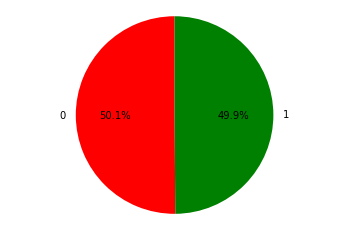

In [0]:
#Label frequency
labels="0","1"
sizes=[sum(df["Target"]==0),sum(df["Target"]==1)]
colors=["red","green"]
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',startangle=90)
plt.axis('equal')
plt.show()

## Data Processing - Feature Engineering

Implement three different technical indicators for predictive features. We will use one trend following, one momentum, and one volume indicator in order to create a multi-indicator strategy. These features will be created using the Techinical Analysis Library to create these features.
- trend following: bollinger bands
- momentum: relative strength index
- volume: on balance volume

In [0]:
!pip install ta
import ta 

  Created wheel for ta: filename=ta-0.5.20-cp36-none-any.whl size=24033 sha256=1007caa3edb0742a2903d2b7cd67372ece4c94bca1d22b5a4a51ba142349b798
  Stored in directory: /root/.cache/pip/wheels/8a/22/4a/8c797d97dfc07b92bbe9294969ce1d55c1d4bf16e1cc2c1320
Successfully built ta


In [0]:
#Initialize Bollinger Bands
indicator_bb = ta.volatility.BollingerBands(close = df["Last"], n=20, ndev=2)

#Add Bollinger Bands features
df['bbMAV'] = indicator_bb.bollinger_mavg()
df['bbHiBand'] = indicator_bb.bollinger_hband()
df['bbLoBand'] = indicator_bb.bollinger_lband()

In [0]:
#Initialize Relative Strength Index
indicator_rsi = ta.momentum.RSIIndicator(close = df["Last"], n = 14, fillna = False)

#Add Relative Strength Index feature
df['RSI'] = indicator_rsi.rsi()

In [0]:
#Initialize On Balance Volume
indicator_obv = ta.volume.OnBalanceVolumeIndicator(close = df['Last'], volume = df['Volume'], fillna = False)

#Add On Balance Volume feature
df['OBV'] = indicator_obv.on_balance_volume()

In [0]:
df.head()

Time    Open    High  ...    bbLoBand         RSI       OBV
119937   5/5/2008 9:40  140.88  141.13  ...  141.110000  100.000000   3227100
119936   5/5/2008 9:50  141.11  141.35  ...  141.075000  100.000000   6934900
119935  5/5/2008 10:00  141.19  141.61  ...  140.899897  100.000000  15435700
119934  5/5/2008 10:10  141.54  141.55  ...  140.884123   48.443665  10062300
119933  5/5/2008 10:20  141.11  141.20  ...  140.709643   35.356519   6641000

[5 rows x 12 columns]

## Data Processing - Cleaning Data
Break apart time column into 6 different seperate columns, each column will be a piece of the date or time.

In [0]:
df['Date'] = pd.to_datetime(df['Time'], yearfirst = True, format = '%m/%d/%Y %H:%M')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Hour'] = df['Date'].dt.hour
df['Minute'] = df['Date'].dt.minute

In [0]:
#Drop "Time" column for further analysis
df = df[['Year', 'Month', 'Day', 'Hour','Minute', 'Open', 'High', 'Low', 'Last', 'Volume', 'bbMAV', 'bbHiBand', 'bbLoBand', 'RSI', 'OBV', 'Target']]
df.head()

Year  Month  Day  Hour  ...    bbLoBand         RSI       OBV  Target
119937  2008      5    5     9  ...  141.110000  100.000000   3227100     1.0
119936  2008      5    5     9  ...  141.075000  100.000000   6934900     1.0
119935  2008      5    5    10  ...  140.899897  100.000000  15435700     0.0
119934  2008      5    5    10  ...  140.884123   48.443665  10062300     0.0
119933  2008      5    5    10  ...  140.709643   35.356519   6641000     1.0

[5 rows x 16 columns]

## Data Preparation for Model

In [0]:
df.head()

Year  Month  Day  Hour  ...    bbLoBand         RSI       OBV  Target
119937  2008      5    5     9  ...  141.110000  100.000000   3227100     1.0
119936  2008      5    5     9  ...  141.075000  100.000000   6934900     1.0
119935  2008      5    5    10  ...  140.899897  100.000000  15435700     0.0
119934  2008      5    5    10  ...  140.884123   48.443665  10062300     0.0
119933  2008      5    5    10  ...  140.709643   35.356519   6641000     1.0

[5 rows x 16 columns]

In [0]:
#Scale values to between 0 and 1 for easier training
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaledFeatures =  MinMaxScaler().fit_transform(df)
df = pd.DataFrame(scaledFeatures, columns = ['Year', 'Month', 'Day', 'Hour','Minute', 'Open', 'High', 'Low', 'Last', 'Volume', 'bbMAV', 'bbHiBand', 'bbLoBand', 'RSI', 'OBV', 'Target'])

In [0]:
#Look at min and max 
df.describe()

Year          Month  ...            OBV         Target
count  119937.000000  119937.000000  ...  119937.000000  119937.000000
mean        0.485845       0.502978  ...       0.601150       0.498837
std         0.289564       0.311345  ...       0.308559       0.500001
min         0.000000       0.000000  ...       0.000000       0.000000
25%         0.250000       0.272727  ...       0.357947       0.000000
50%         0.500000       0.545455  ...       0.658238       0.000000
75%         0.750000       0.818182  ...       0.911017       1.000000
max         1.000000       1.000000  ...       1.000000       1.000000

[8 rows x 16 columns]

In [0]:
dataset = df.values
print(dataset)
print(len(dataset))

[[0.         0.36363636 0.13333333 ... 1.         0.04745235 1.        ]
 [0.         0.36363636 0.13333333 ... 1.         0.04784542 1.        ]
 [0.         0.36363636 0.13333333 ... 1.         0.0487466  0.        ]
 ...
 [1.         0.27272727 0.76666667 ... 0.71485656 0.99899413 1.        ]
 [1.         0.27272727 0.76666667 ... 0.73716155 0.99932881 0.        ]
 [1.         0.27272727 0.76666667 ... 0.6551405  0.99858819 0.        ]]
119937


In [0]:
#Split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		#Find the end of this pattern
		end_ix = i + n_steps
		#Check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		#Gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [0]:
#Choose a number of time steps
n_steps = 3
#Split into samples
X, y = split_sequences(dataset, n_steps)

print(X)
print(y)

[[[0.         0.36363636 0.13333333 ... 0.27404512 1.         0.04745235]
  [0.         0.36363636 0.13333333 ... 0.27391646 1.         0.04784542]
  [0.         0.36363636 0.13333333 ... 0.27327278 1.         0.0487466 ]]

 [[0.         0.36363636 0.13333333 ... 0.27391646 1.         0.04784542]
  [0.         0.36363636 0.13333333 ... 0.27327278 1.         0.0487466 ]
  [0.         0.36363636 0.13333333 ... 0.2732148  0.44572009 0.04817696]]

 [[0.         0.36363636 0.13333333 ... 0.27327278 1.         0.0487466 ]
  [0.         0.36363636 0.13333333 ... 0.2732148  0.44572009 0.04817696]
  [0.         0.36363636 0.13333333 ... 0.27257341 0.30502075 0.04781426]]

 ...

 [[1.         0.27272727 0.76666667 ... 0.78107328 0.65954573 0.99858874]
  [1.         0.27272727 0.76666667 ... 0.78135353 0.69828598 0.99876707]
  [1.         0.27272727 0.76666667 ... 0.78176919 0.71485656 0.99899413]]

 [[1.         0.27272727 0.76666667 ... 0.78135353 0.69828598 0.99876707]
  [1.         0.27272727

In [0]:
#Reshape from [samples, timesteps] into [samples, batch, timesteps, features]
n_features = 15
batch = 1
n_steps = 3
X = X.reshape((X.shape[0], batch, n_steps, n_features))
print(X.shape)
print(len(X))
print(len(y))

(119935, 1, 3, 15)
119935
119935


In [0]:
#Creating train, validation, and test sets
#Test set is the last day in data set 4/24/2020
lenTrain, lenVal = 119000,895
X_train, X_val, X_test = X[:lenTrain], X[lenTrain:(lenTrain+lenVal)], X[(lenTrain+lenVal):]
y_train, y_val, y_test = y[:lenTrain], y[lenTrain:(lenTrain+lenVal)], y[(lenTrain+lenVal):]

## Model - Building
Academic Literature suggests a combination of LSTMs and CNNs will provide best results for time series classification.

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import TimeDistributed
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

Using TensorFlow backend.


In [0]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters = 128, kernel_size = 8, padding='same', activation = 'relu', kernel_initializer='he_uniform'), input_shape=(batch, n_steps, n_features)))
model.add(TimeDistributed(Conv1D(filters = 256, kernel_size = 8, padding='same', activation = 'relu', kernel_initializer='he_uniform')))
model.add(TimeDistributed(Conv1D(filters = 128, kernel_size = 8, padding='same', activation = 'relu', kernel_initializer='he_uniform')))
model.add(TimeDistributed(MaxPooling1D(pool_size = 2, data_format = 'channels_last')))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(64, activation='relu', dropout = .8, return_sequences = True))
model.add(LSTM(32, activation='relu', dropout = .8, return_sequences = True))
model.add(LSTM(16, activation='relu', dropout = .8))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss='binary_crossentropy' , metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 1, 3, 128)         15488     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 3, 256)         262400    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 3, 128)         262272    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 1, 1, 128)         0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 1, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 64)             49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 32)            

## Model - Training and Eval

In [0]:
model.fit(X_train, y_train, epochs=500, validation_data=(X_val,y_val))

Train on 119000 samples, validate on 895 samples
Epoch 1/500
119000/119000 [==============================] - 59s 499us/step - loss: 0.8386 - accuracy: 0.4988 - val_loss: 0.6923 - val_accuracy: 0.5207
Epoch 2/500
119000/119000 [==============================] - 50s 424us/step - loss: 0.6938 - accuracy: 0.4992 - val_loss: 0.6937 - val_accuracy: 0.4793
Epoch 3/500
119000/119000 [==============================] - 50s 424us/step - loss: 0.6934 - accuracy: 0.5001 - val_loss: 0.6944 - val_accuracy: 0.4793
Epoch 4/500
119000/119000 [==============================] - 51s 430us/step - loss: 0.6934 - accuracy: 0.5009 - val_loss: 0.6939 - val_accuracy: 0.4793
Epoch 5/500
119000/119000 [==============================] - 51s 425us/step - loss: 0.6936 - accuracy: 0.5003 - val_loss: 0.6950 - val_accuracy: 0.4793
Epoch 6/500
119000/119000 [==============================] - 50s 421us/step - loss: 0.6934 - accuracy: 0.5012 - val_loss: 0.6925 - val_accuracy: 0.5207
Epoch 7/500
119000/119000 [============

In [0]:
yhat = model.predict_classes(X_test, verbose=1)
print(yhat)

40/40 [==============================] - 0s 4ms/step
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]


In [0]:
#Precision tp / (tp + fp)
precision = precision_score(y_test, yhat)
print('Precision: %f' % precision)
#Recall: tp / (tp + fn)
recall = recall_score(y_test, yhat)
print('Recall: %f' % recall)

Precision: 0.600000
Recall: 1.000000


## Model - Testing
Testing data consists of intraday by minute data from 4/27/2020 to 4/29/2020.

In [0]:
dftest = pd.read_csv('SPYIntraday_april272020ToApril292020.csv')

In [0]:
#Reordering
dftest = dftest.sort_index(ascending=True, axis=0)
dftest = dftest.reindex(index=dftest.index[::-1])
dftest = dftest.drop(dftest.index[0])
dftest.head()

Time    Open    High     Low      Last  Change     Volume
119  04/27/20 09:30  285.12  285.63  284.81  285.4600  2.5700  2142385.0
118  04/27/20 09:40  285.46  285.51  284.62  285.1300 -0.3300  1530215.0
117  04/27/20 09:50  285.13  285.75  284.92  285.5200  0.3900  1842409.0
116  04/27/20 10:00  285.52  285.78  285.16  285.4425 -0.0775  1998954.0
115  04/27/20 10:10  285.44  286.10  285.16  286.0921  0.6496  1295773.0

In [0]:
#Creating Label
conditions = [dftest['Change'] <= 0, dftest['Change'] > 0]
choices = [0, 1]
dftest['Change'] = np.select(conditions, choices)
dftest['Change'] = dftest['Change'].shift(-1)
dftest = dftest.drop(dftest.tail(1).index)
dftest['Target'] = dftest['Change']
dftest = dftest[['Time', 'Open', 'High', 'Low', 'Last', 'Volume', 'Target']]
dftest.head()

Time    Open    High     Low      Last     Volume  Target
119  04/27/20 09:30  285.12  285.63  284.81  285.4600  2142385.0     0.0
118  04/27/20 09:40  285.46  285.51  284.62  285.1300  1530215.0     1.0
117  04/27/20 09:50  285.13  285.75  284.92  285.5200  1842409.0     0.0
116  04/27/20 10:00  285.52  285.78  285.16  285.4425  1998954.0     1.0
115  04/27/20 10:10  285.44  286.10  285.16  286.0921  1295773.0     0.0

In [0]:
#Feature Engineering
#Initialize Bollinger Bands
indicator_bb = ta.volatility.BollingerBands(close = dftest["Last"], n=20, ndev=2)

#Add Bollinger Bands features
dftest['bbMAV'] = indicator_bb.bollinger_mavg()
dftest['bbHiBand'] = indicator_bb.bollinger_hband()
dftest['bbLoBand'] = indicator_bb.bollinger_lband()

#Initialize Relative Strength Index
indicator_rsi = ta.momentum.RSIIndicator(close = dftest["Last"], n = 14, fillna = False)

#Add Relative Strength Index feature
dftest['RSI'] = indicator_rsi.rsi()

#Initialize On Balance Volume
indicator_obv = ta.volume.OnBalanceVolumeIndicator(close = dftest['Last'], volume = dftest['Volume'], fillna = False)

#Add On Balance Volume feature
dftest['OBV'] = indicator_obv.on_balance_volume()

dftest.head()

Time    Open    High  ...    bbLoBand         RSI        OBV
119  04/27/20 09:30  285.12  285.63  ...  285.460000  100.000000  2142385.0
118  04/27/20 09:40  285.46  285.51  ...  284.965000    0.000000   612170.0
117  04/27/20 09:50  285.13  285.75  ...  285.027071   56.000000  2454579.0
116  04/27/20 10:00  285.52  285.78  ...  285.084576   50.007045   455625.0
115  04/27/20 10:10  285.44  286.10  ...  284.903712   74.571373  1751398.0

[5 rows x 12 columns]

In [0]:
dftest['Date'] = pd.to_datetime(dftest['Time'], yearfirst = True, format = None)
dftest['Year'] = dftest['Date'].dt.year
dftest['Month'] = dftest['Date'].dt.month
dftest['Day'] = dftest['Date'].dt.day
dftest['Hour'] = dftest['Date'].dt.hour
dftest['Minute'] = dftest['Date'].dt.minute
dftest = dftest[['Year', 'Month', 'Day', 'Hour','Minute', 'Open', 'High', 'Low', 'Last', 'Volume', 'bbMAV', 'bbHiBand', 'bbLoBand', 'RSI', 'OBV', 'Target']]
dftest.head()

Year  Month  Day  Hour  ...    bbLoBand         RSI        OBV  Target
119  2020      4   27     9  ...  285.460000  100.000000  2142385.0     0.0
118  2020      4   27     9  ...  284.965000    0.000000   612170.0     1.0
117  2020      4   27     9  ...  285.027071   56.000000  2454579.0     0.0
116  2020      4   27    10  ...  285.084576   50.007045   455625.0     1.0
115  2020      4   27    10  ...  284.903712   74.571373  1751398.0     0.0

[5 rows x 16 columns]

In [0]:
#Scale values to between 0 and 1 for easier handling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaledFeatures =  MinMaxScaler().fit_transform(dftest)
dftest = pd.DataFrame(scaledFeatures, columns = ['Year', 'Month', 'Day', 'Hour','Minute', 'Open', 'High', 'Low', 'Last', 'Volume', 'bbMAV', 'bbHiBand', 'bbLoBand', 'RSI', 'OBV', 'Target'])
dataset = dftest.values
print(dataset)
print(len(dataset))

[[0.         0.         0.         ... 1.         0.71037989 0.        ]
 [0.         0.         0.         ... 0.         0.64998912 1.        ]
 [0.         0.         0.         ... 0.56       0.72270079 0.        ]
 ...
 [0.         0.         1.         ... 0.64879629 0.77272116 0.        ]
 [0.         0.         1.         ... 0.64505743 0.61736362 0.        ]
 [0.         0.         1.         ... 0.48179943 0.22810548 0.        ]]
119


In [0]:
#Choose a number of time steps
n_steps = 3
#Split into samples
X, y = split_sequences(dataset, n_steps)

print(X)
print(y)

[[[0.         0.         0.         ... 0.12167428 1.         0.71037989]
  [0.         0.         0.         ... 0.0634755  0.         0.64998912]
  [0.         0.         0.         ... 0.07077344 0.56       0.72270079]]

 [[0.         0.         0.         ... 0.0634755  0.         0.64998912]
  [0.         0.         0.         ... 0.07077344 0.56       0.72270079]
  [0.         0.         0.         ... 0.07753441 0.50007045 0.64381099]]

 [[0.         0.         0.         ... 0.07077344 0.56       0.72270079]
  [0.         0.         0.         ... 0.07753441 0.50007045 0.64381099]
  [0.         0.         0.         ... 0.05626963 0.74571373 0.69494937]]

 ...

 [[0.         0.         1.         ... 0.99176962 0.64536129 0.75626667]
  [0.         0.         1.         ... 0.99120504 0.67951734 0.85802033]
  [0.         0.         1.         ... 0.99700526 0.64879629 0.77272116]]

 [[0.         0.         1.         ... 0.99120504 0.67951734 0.85802033]
  [0.         0.        

In [0]:
#Reshape from [samples, timesteps] into [samples, batch, timesteps, features]
n_features = 15
batch = 1
n_steps = 3
X = X.reshape((X.shape[0], batch, n_steps, n_features))
print(X.shape)
print(len(X))
print(len(y))

(117, 1, 3, 15)
117
117


In [0]:
ytest = model.predict_classes(X, verbose=1)
print(ytest)

117/117 [==============================] - 0s 281us/step
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]


In [0]:
#Precision tp / (tp + fp)
precision = precision_score(y, ytest)
print('Precision: %f' % precision)
#Recall: tp / (tp + fn)
recall = recall_score(y, ytest)
print('Recall: %f' % recall)

Precision: 0.529915
Recall: 1.000000
